# Time-Continuous Density Estimation

This tutorial aims to guide you through the process of Time-Continuous Density Estimation using Mellon.
The density estimate helps in understanding how the probability of a specific cell state
existing in the tissue variesvaries over time.

Let's start by importing the necessary modules:

In [1]:
import numpy as np
import pandas as pd

import mellon
import scanpy as sc

import matplotlib
import matplotlib.pyplot as plt

Here's how you can set up your notebook to display matplotlib graphics and configure some aesthetic parameters.

In [2]:
# This line enables the interactive display of figures in Jupyter notebook.
%matplotlib inline

# Customize matplotlib settings
matplotlib.rcParams['figure.dpi'] = 100  # Adjusts the resolution of the figure.
matplotlib.rcParams['image.cmap'] = 'Spectral_r'  # Sets the default colormap.
matplotlib.rcParams['figure.figsize'] = [6, 6]  # Defines the default figure size.

# Disabling the axes for a more minimalistic plot look:
matplotlib.rcParams['axes.spines.bottom'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.left'] = False
matplotlib.rcParams['axes.spines.right'] = False

## Step 1: Reading and Displaying the Dataset

InitiallyInitially, we will load the RNA AnnData file from a provided URL, saving it to a local disk for further analysis. If you prefer to store this file at a different location, modify the rna_annData_file path accordingly. The dataset contains preprocessed information pertaining to the mouse gastrulation atlas.

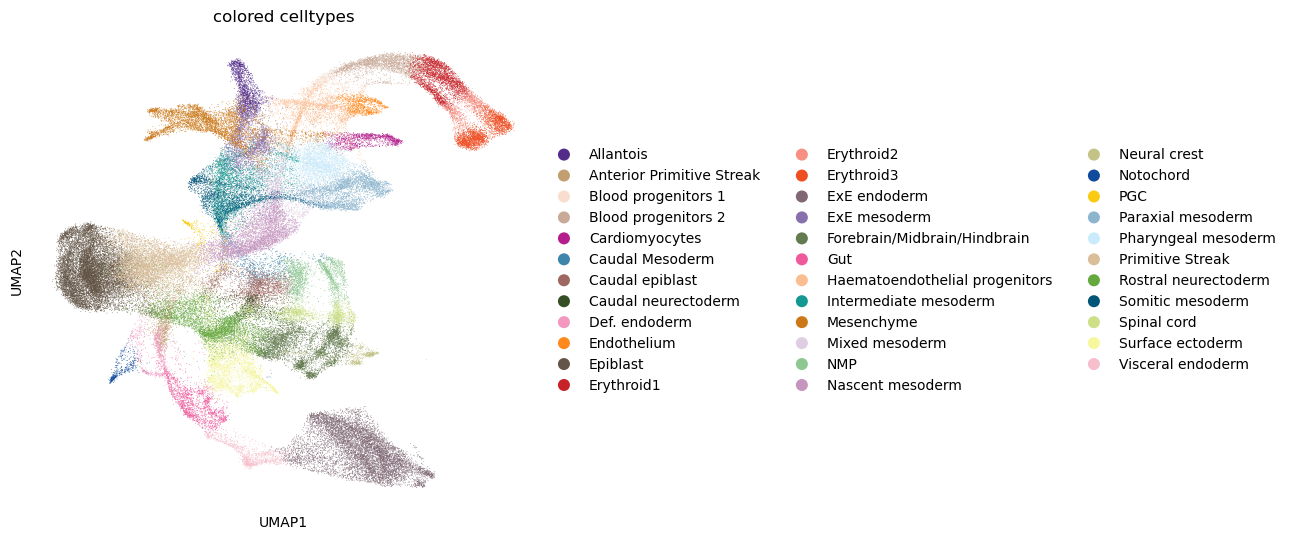

In [3]:
url = "https://fh-pi-setty-m-eco-public.s3.amazonaws.com/mellon-tutorial/preprocessed_mouse-gastrulation-atlas.h5ad"
rna_annData_file = "data/preprocessed_mouse-gastrulation-atlas.h5ad"
ad = sc.read(rna_annData_file, backup_url=url)
sc.pl.scatter(ad, basis="umap", color="colored_celltypes")

## Step 2: Numerical Representation of Time

The time at which the samples were taken must be present as a numerical value. This will help us assess the similarity of different samples based on their time of collection.

In [4]:
stage_to_numerical = {
    "E6.5": 6.5,
    "E6.75": 6.75,
    "E7.0": 7.0,
    "E7.25": 7.25,
    "E7.5": 7.5,
    "E7.75": 7.75,
    "E8.0": 8.0,
    "E8.25": 8.25,
    "E8.5": 8.5,
}
numerical_to_stage = {n: s for s, n in stage_to_numerical.items()}

ad.obs["stage_numerical"] = pd.Series(ad.obs["stage"].map(stage_to_numerical), dtype=float)

sampled_times = ad.obs[["stage", "stage_numerical"]].drop_duplicates(ignore_index=True)
sampled_times

,stage,stage_numerical
0,E6.5,6.50
1,E7.5,7.50
2,E6.75,6.75
3,E7.75,7.75
4,E7.0,7.00
5,E8.0,8.00
6,E8.5,8.50
7,E7.25,7.25
8,E8.25,8.25


## Step 3: Time-Continuous Density Estimation

We'll use the Time-Sensitive Density Estimator to understand the changing densities in our data over time. The intrinsic dimensionality is set to 2, which doesn't greatly influence the final density ranking but makes the conversion from log-density to linear density more straightforward later.

In [5]:
%%time
X = ad.obsm["DM_EigenVectors"]
X_times = ad.obs["stage_numerical"]

# Initialize the time-sensitive density estimator with an intrinsic dimensionality of 2
t_est = mellon.TimeSensitiveDensityEstimator(d=2, ls_time=0.375)

# Fit the estimator to the data
t_est.fit(X, X_times)

# Save the predictor for later density evaluations
density_predictor = t_est.predict

[2023-06-23 00:51:29,881] [INFO    ] Computing nearest neighbor distances within time points.
[2023-06-23 00:51:41,387] [INFO    ] Using covariance function (Matern52(ls=0.0028995675014713263, active_dims=slice(None, -1, None)) * Matern52(ls=0.375, active_dims=-1)).
[2023-06-23 00:51:41,495] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2023-06-23 00:52:13,766] [INFO    ] Doing low-rank Cholesky decomposition for 98,192 samples and 5,000 landmarks.
[2023-06-23 00:53:14,094] [INFO    ] Estimating approximation accuracy since 98,192 samples are more than 10 x 5,000 landmarks.
[2023-06-23 00:53:57,217] [WARNING ] High approx. rank fraction (91.3%). Consider increasing 'n_landmarks'.
[2023-06-23 00:53:57,220] [INFO    ] Using rank 5,000 covariance representation.
[2023-06-23 00:54:04,065] [INFO    ] Running inference using L-BFGS-B.
[2023-06-23 00:56:20,403] [INFO    ] Computing predictive function.
CPU times: user 16min 38s, sys: 9min 47s, total: 26min 26s
Wall time: 4min

## Step 4: Density Evaluation and Plotting

The cell-state density can be evaluated for any time point. For instance, we can evaluate the density for all cell states at stage E7.20.

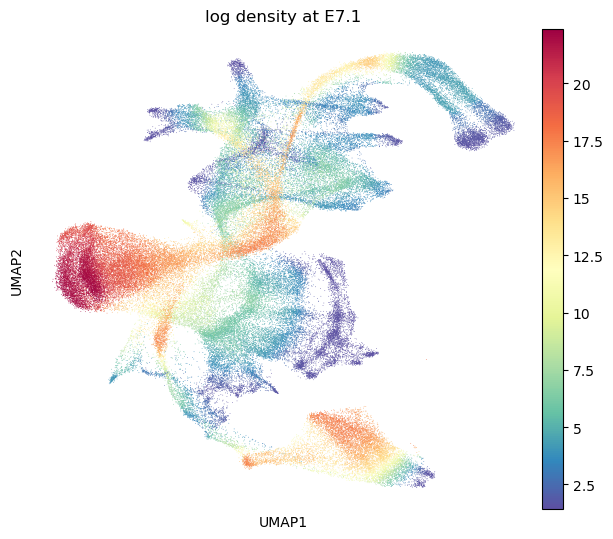

CPU times: user 39.2 s, sys: 1min 31s, total: 2min 10s
Wall time: 43.1 s


In [6]:
%%time
time = 7.10
ad.obs[f"log_density_at_E{time}"] = density_predictor(X, time)

sc.pl.scatter(ad, basis="umap", color=f"log_density_at_E{time}")

Similarly, we can compute the rate of density change for any time point and cell state.

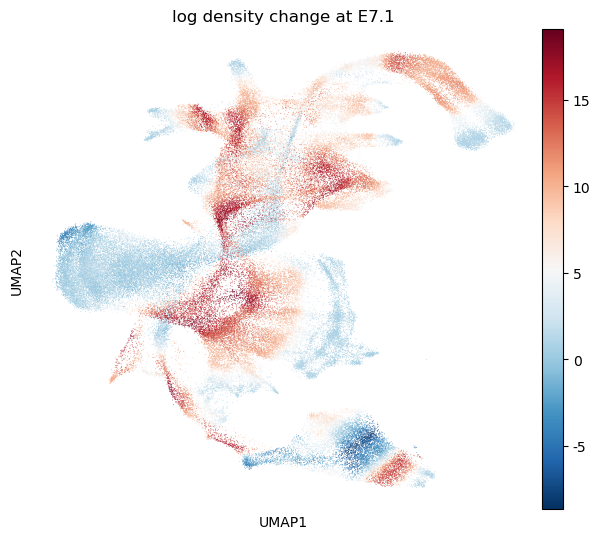

CPU times: user 29.9 s, sys: 23 s, total: 52.9 s
Wall time: 11.3 s


In [7]:
%%time
ad.obs[f"log_density_change_at_E{time}"] = density_predictor.time_derivative(X, time)

sc.pl.scatter(
    ad, basis="umap", color=f"log_density_change_at_E{time}", color_map="RdBu_r"
)

## Step 5: Generating a Continuous Trajectory

We can use mellon to determine a continuous differentiation trajectory through the selected cell-state space. For illustration, we will start by finding a continuous trajectory through the UMAP state representation of cells.

In [8]:
%%time
idx = ad.obsm["branch_masks"]["Erythroid3"]
pseudotime = ad.obs.loc[idx, "palantir_pseudotime"].values
pseudotime_grid = np.linspace(np.min(pseudotime), np.max(pseudotime), 200)

umap_est = mellon.FunctionEstimator(ls=1, sigma=5, n_landmarks=10)
umap_trajectory = umap_est.fit_predict(
    pseudotime, ad.obsm["X_umap"][idx, :], pseudotime_grid
)

[2023-06-23 00:57:18,110] [INFO    ] Using covariance function Matern52(ls=1.0).
[2023-06-23 00:57:18,140] [INFO    ] Computing 10 landmarks with k-means clustering.
CPU times: user 1.96 s, sys: 1.16 s, total: 3.11 s
Wall time: 1.53 s


This trajectory can be visualized using matplotlib.

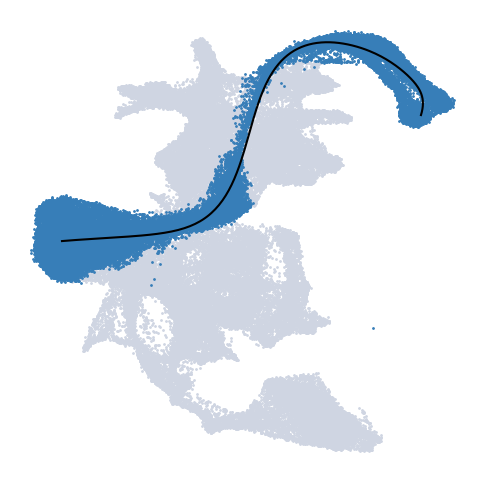

In [9]:
fig, ax = plt.subplots(1, 1)
ax.scatter(ad.obsm["X_umap"][~idx, 0], ad.obsm["X_umap"][~idx, 1], c="#CFD5E2", s=1)
ax.scatter(ad.obsm["X_umap"][idx, 0], ad.obsm["X_umap"][idx, 1], c="#377EB8", s=1)
ax.plot(umap_trajectory[:, 0], umap_trajectory[:, 1], color="black")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Step 6: Saving the Predictor

The density predictor can be serialized and saved for future use. It can be stored in the AnnData `uns` attribute, and the AnnData can be saved with the `write` method. The predictor can be reconstructed using the `from_dict` method of `mellon.Predictor`.

In [10]:
ad.uns["density_predictor"] = density_predictor.to_dict()

To save the AnnData:

In [ ]:
ad.write("data/preprocessed_mouse-gastrulation-atlas_with_density_predictor.h5ad")

To reconstruct the predictor:

In [12]:
density_predictor = mellon.Predictor.from_dict(ad.uns["density_predictor"])

By the end of this tutorial, you should have a basic understanding of time-continuous density estimation with Mellon
This knowledge can be valuable in many areas of single-cell analysis of developmental and regenerative tissue,
where understanding the dynamics of cell states over time is crucial.